# Stochastic Gradient Descent, Regularization, and Transfer Learning

# **Assignment 4**
### 10 Points

### Use the code of CNNs that you wrote for Assignment 2 and perform the following tasks on CIFAR10 Images:

#### Q1 and Q2 are worth 5 points together, Q3 and Q4 are worth 5 points together.

1.   Use Gradient Descent and Stochastic Gradient Descent (SGD) as the learning algorithms and compare the performance for 100 epochs of training. Plot the Loss vs Epochs on the same graph.

2.   Using SGD for the same example do the following and comapre the results for each case with the base case done in using SGD in part 1.

          1.   Train your network using SGD with momentum = 0.9
          2.   Train your network using SGD with Dropout
          3.   Train your network using SGD with L2 regularization
          
   You should be able to compare the training and test performance for all the three cases with the base case.
   
#### WHAT IS TRANSFER LEARNING?
#### Transfer learning, used in machine learning, is the reuse of a pre-trained model on a new problem. In transfer learning, a machine exploits the knowledge gained from a previous task to improve generalization about another. For example, in training a classifier to predict whether an image contains food, you could use the knowledge it gained during training to recognize drinks. Because transfer learning involves retraining an existing model with a new dataset, the retrained model will consist of knowledge gained from multiple datasets.

3.   Experiments with different CNN architectures that include: AlexNet, VGG, ResNet, and DenseNet. Fine tune the hyperparameters (Optimizers, batch_size, learning rate, etc.) and compare the performance of these architectures.
4. Plot the accuracy and loss for all the architectures on the same plots. Conclude which architecture is best suited for the CIFAR10 dataset.



# Question 1

In [1]:
import torch
import torch.nn.functional as F
from torch import autograd, nn
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import random_split
from tqdm import tqdm
import torch.optim as optim
from torchvision.models import alexnet, vgg16, resnet50, densenet121

In [3]:
## load training dataset
BATCH_SIZE = 512

Mytransform = transforms.Compose([transforms.ToTensor(),transforms.RandomHorizontalFlip(p=0.3)])

trainset = torchvision.datasets.CIFAR10(root='data/train', train=True,
                                        download=True, transform=Mytransform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

## download and load testing dataset
testset = torchvision.datasets.CIFAR10(root='data/test', train=False,
                                       download=True, transform=Mytransform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

print('==>>> total training set number: {}'.format(len(trainset)))
print('==>>> total test set number: {}'.format(len(testset)))

100%|██████████| 170498071/170498071 [00:12<00:00, 13197664.46it/s]


Extracting data/train/cifar-10-python.tar.gz to data/train


100%|██████████| 170498071/170498071 [02:41<00:00, 1058011.01it/s]


Extracting data/test/cifar-10-python.tar.gz to data/test
==>>> total training set number: 50000
==>>> total test set number: 10000


## Base Model without Dropout Layers

In [10]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)  # Move to GPU
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        accu = accuracy(out, labels)
        return loss, accu

    def validation_step(self, batch):
        images, labels = batch
        images, labels = images.to(device), labels.to(device)  # Move to GPU
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'Loss': loss.detach(), 'Accuracy': acc}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['Loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['Accuracy'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'Loss': epoch_loss.item(), 'Accuracy': epoch_acc.item()}

    def epoch_end(self, epoch, result):
      if (epoch+1) % 10 == 0:
        print("Epoch :", epoch + 1)
        print(f'Train Accuracy:{result["train_accuracy"]*100:.4f}% Validation Accuracy:{result["Accuracy"]*100:.4f}%')
        print(f'Train Loss:{result["train_loss"]:.6f} Validation Loss:{result["Loss"]:.6f}')

class Mycnn(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.network(x)

# Check for device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

# Create model instance and move to GPU if available
model = Mycnn().to(device)

Using cuda device.


# PART 1

# Question 1

In [11]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def fit_sgd(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    best_valid = None
    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # Using SGD optimizer
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in train_loader:
            loss, accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

def fit_gd(model, train_loader, val_loader, epochs=10, learning_rate=0.001):
    best_valid = None
    history = []
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)  # Using plain Gradient Descent
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in train_loader:
            loss, accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()

        # Update parameters using gradients from entire dataset
        optimizer.step()
        optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

model_sgd = Mycnn().to(device)
model_gd = Mycnn().to(device)

print("Running Gradient Descent")
history_gd = fit_gd(model_gd, trainloader, testloader, 100, 0.001)

print("\nRunning Stochastic Gradient Descent")
history_sgd = fit_sgd(model_sgd, trainloader, testloader, 100, 0.001)

Running Gradient Descent
Epoch : 10
Train Accuracy:32.2394% Validation Accuracy:12.8699%
Train Loss:1.929626 Validation Loss:4.364477
Epoch : 20
Train Accuracy:39.6372% Validation Accuracy:32.2478%
Train Loss:1.715151 Validation Loss:1.864345
Epoch : 30
Train Accuracy:42.8159% Validation Accuracy:28.8367%
Train Loss:1.561359 Validation Loss:2.106924
Epoch : 40
Train Accuracy:43.9881% Validation Accuracy:29.9971%
Train Loss:1.520279 Validation Loss:2.042665
Epoch : 50
Train Accuracy:50.4949% Validation Accuracy:34.8288%
Train Loss:1.393705 Validation Loss:1.863886
Epoch : 60
Train Accuracy:51.6244% Validation Accuracy:39.4376%
Train Loss:1.330191 Validation Loss:1.783189
Epoch : 70
Train Accuracy:48.6318% Validation Accuracy:38.3887%
Train Loss:1.378141 Validation Loss:1.836624
Epoch : 80
Train Accuracy:52.8800% Validation Accuracy:27.0295%
Train Loss:1.255861 Validation Loss:2.811923
Epoch : 90
Train Accuracy:56.9996% Validation Accuracy:35.9978%
Train Loss:1.190874 Validation Loss:1.9

## Plotting training accuracy for base GD and SGD

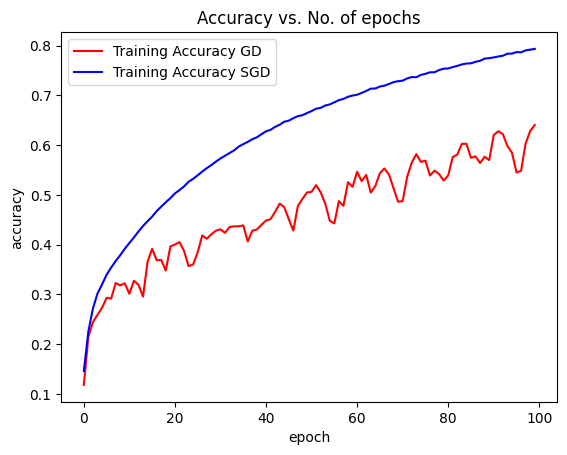

In [12]:
Training_Accuracies_gd = [x['train_accuracy'] for x in history_gd]
Training_Accuracies_sgd = [x['train_accuracy'] for x in history_sgd]
plt.plot(Training_Accuracies_gd, '-r')
plt.plot(Training_Accuracies_sgd, '-b')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training Accuracy GD', 'Training Accuracy SGD'])
plt.title('Accuracy vs. No. of epochs');


## Plotting loss for base GD and SGD

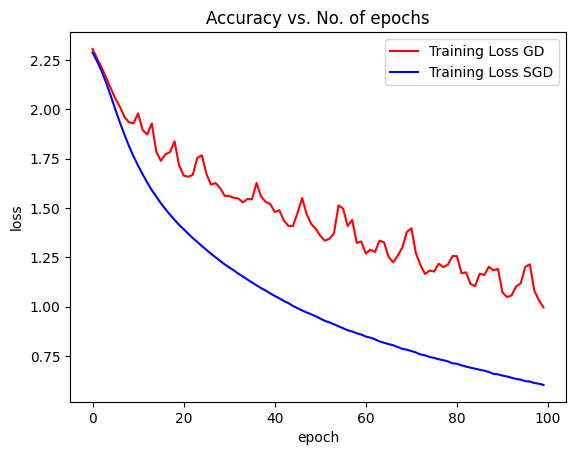

In [13]:
Training_Loss_gd = [x['train_loss'] for x in history_gd]
Training_Loss_sgd = [x['train_loss'] for x in history_sgd]
plt.plot(Training_Loss_gd, '-r')
plt.plot(Training_Loss_sgd, '-b')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training Loss GD', 'Training Loss SGD'])
plt.title('Accuracy vs. No. of epochs');

From the graphs, can see SGD converges much faster than simple GD as expected.

# Question 2

New model to inlcude dropout layers

In [5]:
class Mycnn_drop_out(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 16 x 16
            nn.BatchNorm2d(64),
            nn.Dropout(0.25), # Add dropout layer

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 128 x 8 x 8
            nn.BatchNorm2d(128),
            nn.Dropout(0.25), # Add dropout layer

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 256 x 4 x 4
            nn.BatchNorm2d(256),
            nn.Dropout(0.25), # Add dropout layer

            nn.Flatten(),
            nn.Linear(256*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.5), # Add dropout layer
            nn.Linear(512, 10)
        )

    def forward(self, x):
        return self.network(x)

In [6]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

def evaluate(model, data_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in data_loader]
    return model.validation_epoch_end(outputs)

def fit_custom(model, train_loader, val_loader, epochs=10, learning_rate=0.001, setting = 0): # setting 1 = momentum, 2 = dropout , 3 = weight decay
    best_valid = None
    history = []
    if setting == 1:
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)  # adding momentum
    elif setting == 2:
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # model used will include dropout layers so use base SGD
    elif setting == 3:
      optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=0.0005)  # adding weight decay for L2 regularization
    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in train_loader:
            loss, accu = model.training_step(batch)
            train_losses.append(loss)
            train_accuracy.append(accu)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_accuracy'] = torch.stack(train_accuracy).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


model_mom = Mycnn().to(device)
model_dropout = Mycnn_drop_out().to(device)
model_l2_reg = Mycnn().to(device)

print("Running SGD w/ Momentum")
history_mom = fit_custom(model_mom, trainloader, testloader, 100, 0.001, 1)

print("Running SGD w/ Dropout Layers")
history_dropout = fit_custom(model_dropout, trainloader, testloader, 100, 0.001, 2)

print("Running SGD w/ L2 Regularization")
history_l2_reg = fit_custom(model_l2_reg, trainloader, testloader, 100, 0.001, 3)


Running SGD w/ Momentum
Epoch : 50
Train Accuracy:99.9741% Validation Accuracy:79.5393%
Train Loss:0.010176 Validation Loss:0.828013
Epoch : 100
Train Accuracy:100.0000% Validation Accuracy:79.9701%
Train Loss:0.001355 Validation Loss:0.968071
Running SGD w/ Dropout Layers
Epoch : 50
Train Accuracy:52.5673% Validation Accuracy:53.3668%
Train Loss:1.290197 Validation Loss:1.282860
Epoch : 100
Train Accuracy:64.8314% Validation Accuracy:50.7026%
Train Loss:0.976870 Validation Loss:1.492764
Running SGD w/ L2 Regularization
Epoch : 50
Train Accuracy:65.8356% Validation Accuracy:63.0957%
Train Loss:0.969222 Validation Loss:1.032909
Epoch : 100
Train Accuracy:78.8474% Validation Accuracy:70.5664%
Train Loss:0.617526 Validation Loss:0.826007


## Plotting Accuracy for Base vs. each configuration

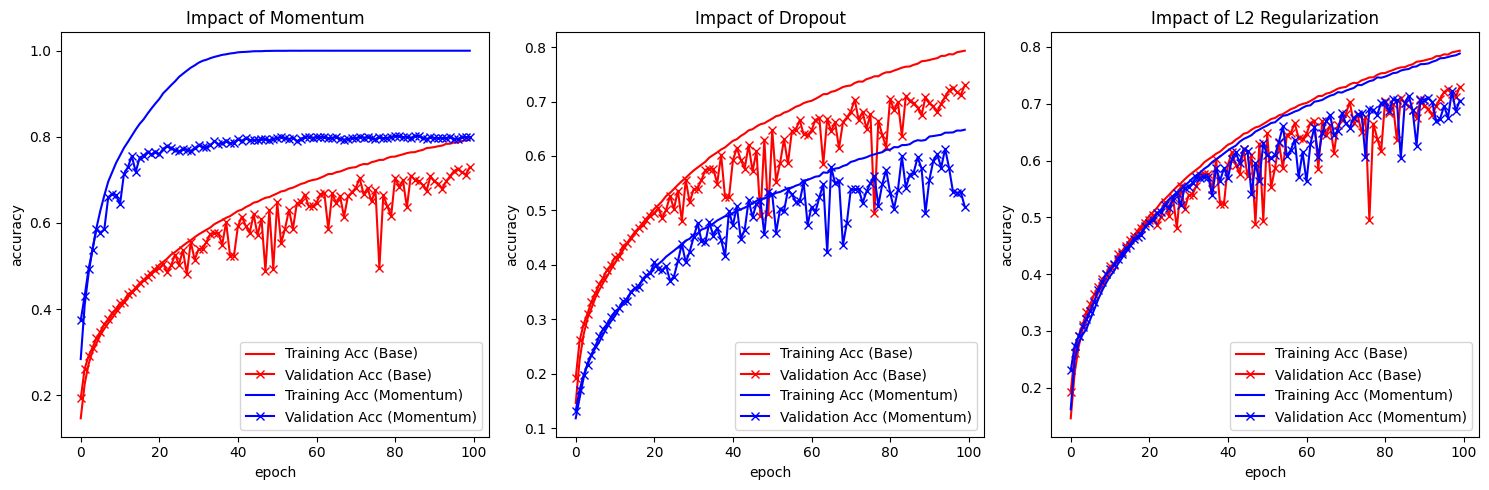

In [14]:
plt.figure(figsize=(15, 5))

Training_Accuracies_base = [x['train_accuracy'] for x in history_sgd]
Validation_accuracies_base = [x['Accuracy'] for x in history_sgd]

Training_Accuracies_mom = [x['train_accuracy'] for x in history_mom]
Validation_accuracies_mom = [x['Accuracy'] for x in history_mom]

Training_Accuracies_drop = [x['train_accuracy'] for x in history_dropout]
Validation_accuracies_drop = [x['Accuracy'] for x in history_dropout]

Training_Accuracies_l2_reg = [x['train_accuracy'] for x in history_l2_reg]
Validation_accuracies_l2_reg = [x['Accuracy'] for x in history_l2_reg]

plt.subplot(1, 3, 1)
plt.plot(Training_Accuracies_base, '-r')
plt.plot(Validation_accuracies_base, '-rx')
plt.plot(Training_Accuracies_mom, '-b')
plt.plot(Validation_accuracies_mom, '-bx')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training Acc (Base)', 'Validation Acc (Base)', 'Training Acc (Momentum)', 'Validation Acc (Momentum)'])
plt.title('Impact of Momentum')

plt.subplot(1, 3, 2)
plt.plot(Training_Accuracies_base, '-r')
plt.plot(Validation_accuracies_base, '-rx')
plt.plot(Training_Accuracies_drop, '-b')
plt.plot(Validation_accuracies_drop, '-bx')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training Acc (Base)', 'Validation Acc (Base)', 'Training Acc (Momentum)', 'Validation Acc (Momentum)'])
plt.title('Impact of Dropout')

plt.subplot(1, 3, 3)
plt.plot(Training_Accuracies_base, '-r')
plt.plot(Validation_accuracies_base, '-rx')
plt.plot(Training_Accuracies_l2_reg, '-b')
plt.plot(Validation_accuracies_l2_reg, '-bx')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Training Acc (Base)', 'Validation Acc (Base)', 'Training Acc (Momentum)', 'Validation Acc (Momentum)'])
plt.title('Impact of L2 Regularization')

plt.tight_layout()
plt.show()

Based on the above plots, momentum has the largest impact and allows the model to reach the best accuracy the fastest.

## Plotting Loss for Base vs. each configuration

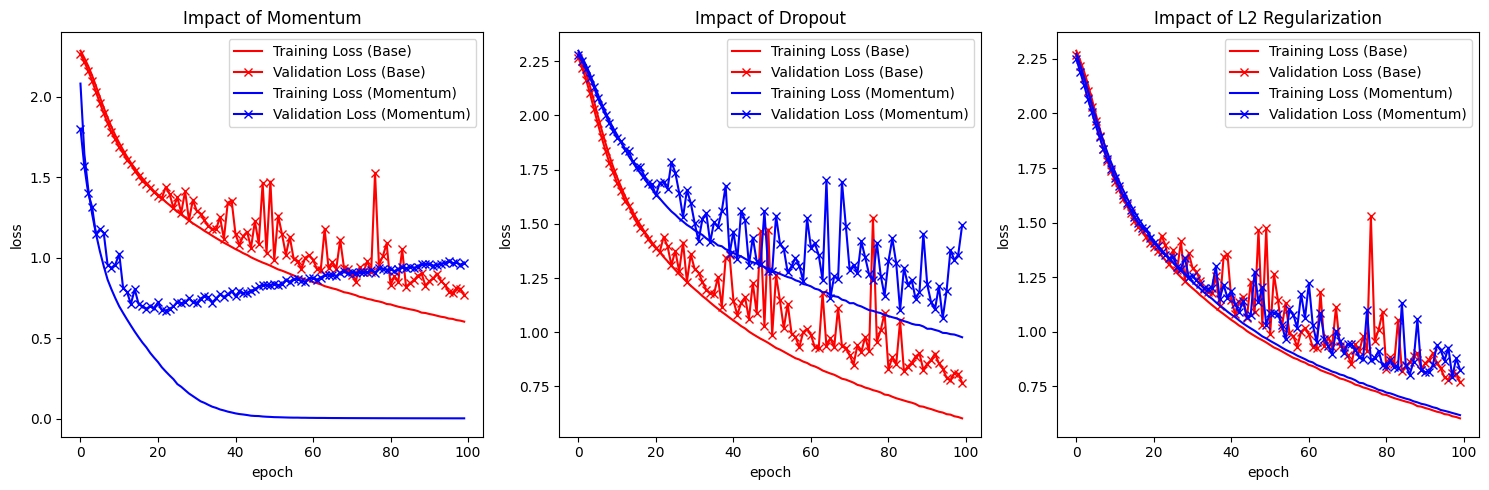

In [16]:
plt.figure(figsize=(15, 5))

Training_loss_base = [x['train_loss'] for x in history_sgd]
Validation_loss_base = [x['Loss'] for x in history_sgd]

Training_loss_mom = [x['train_loss'] for x in history_mom]
Validation_loss_mom = [x['Loss'] for x in history_mom]

Training_loss_drop = [x['train_loss'] for x in history_dropout]
Validation_loss_drop = [x['Loss'] for x in history_dropout]

Training_loss_l2_reg = [x['train_loss'] for x in history_l2_reg]
Validation_loss_l2_reg = [x['Loss'] for x in history_l2_reg]

plt.subplot(1, 3, 1)
plt.plot(Training_loss_base, '-r')
plt.plot(Validation_loss_base, '-rx')
plt.plot(Training_loss_mom, '-b')
plt.plot(Validation_loss_mom, '-bx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training Loss (Base)', 'Validation Loss (Base)', 'Training Loss (Momentum)', 'Validation Loss (Momentum)'])
plt.title('Impact of Momentum')

plt.subplot(1, 3, 2)
plt.plot(Training_loss_base, '-r')
plt.plot(Validation_loss_base, '-rx')
plt.plot(Training_loss_drop, '-b')
plt.plot(Validation_loss_drop, '-bx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training Loss (Base)', 'Validation Loss (Base)', 'Training Loss (Momentum)', 'Validation Loss (Momentum)'])
plt.title('Impact of Dropout')

plt.subplot(1, 3, 3)
plt.plot(Training_loss_base, '-r')
plt.plot(Validation_loss_base, '-rx')
plt.plot(Training_loss_l2_reg, '-b')
plt.plot(Validation_loss_l2_reg, '-bx')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Training Loss (Base)', 'Validation Loss (Base)', 'Training Loss (Momentum)', 'Validation Loss (Momentum)'])
plt.title('Impact of L2 Regularization')

plt.tight_layout()
plt.show()

Once again, momentum is the best for reducing loss the quickest in 100 epochs compared to dropout layers and L2 regularization.

# PART 2

In [2]:
# Load data again into different size
BATCH_SIZE = 512

Mytransform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224 pixels
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

trainset = torchvision.datasets.CIFAR10(root='data/train', train=True,
                                        download=True, transform=Mytransform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=0)

## download and load testing dataset
testset = torchvision.datasets.CIFAR10(root='data/test', train=False,
                                       download=True, transform=Mytransform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=0)

print('==>>> total training set number: {}'.format(len(trainset)))
print('==>>> total test set number: {}'.format(len(testset)))

100%|██████████| 170498071/170498071 [00:02<00:00, 63413503.84it/s]


Extracting data/train/cifar-10-python.tar.gz to data/train


100%|██████████| 170498071/170498071 [00:01<00:00, 90952925.40it/s] 


Extracting data/test/cifar-10-python.tar.gz to data/test
==>>> total training set number: 50000
==>>> total test set number: 10000


In [3]:
models = {
    'AlexNet': alexnet(pretrained=True),
    'VGG16': vgg16(pretrained=True),
    'ResNet50': resnet50(pretrained=True),
    'DenseNet121': densenet121(pretrained=True),
}

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 126MB/s]
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed

Training and testing AlexNet...
Epoch 5: Train Loss: 0.3712, Train Acc: 87.09%, Test Loss: 0.3542, Test Acc: 87.58%
Epoch 10: Train Loss: 0.2795, Train Acc: 90.26%, Test Loss: 0.2921, Test Acc: 89.67%
Training and testing VGG16...
Epoch 5: Train Loss: 0.2241, Train Acc: 92.31%, Test Loss: 0.2576, Test Acc: 91.29%
Epoch 10: Train Loss: 0.1276, Train Acc: 95.58%, Test Loss: 0.2315, Test Acc: 92.32%
Training and testing ResNet50...
Epoch 5: Train Loss: 0.1219, Train Acc: 96.44%, Test Loss: 0.1748, Test Acc: 93.99%
Epoch 10: Train Loss: 0.0382, Train Acc: 99.32%, Test Loss: 0.1524, Test Acc: 94.96%
Training and testing DenseNet121...
Epoch 5: Train Loss: 0.1481, Train Acc: 95.57%, Test Loss: 0.1810, Test Acc: 94.04%
Epoch 10: Train Loss: 0.0575, Train Acc: 98.66%, Test Loss: 0.1503, Test Acc: 94.91%


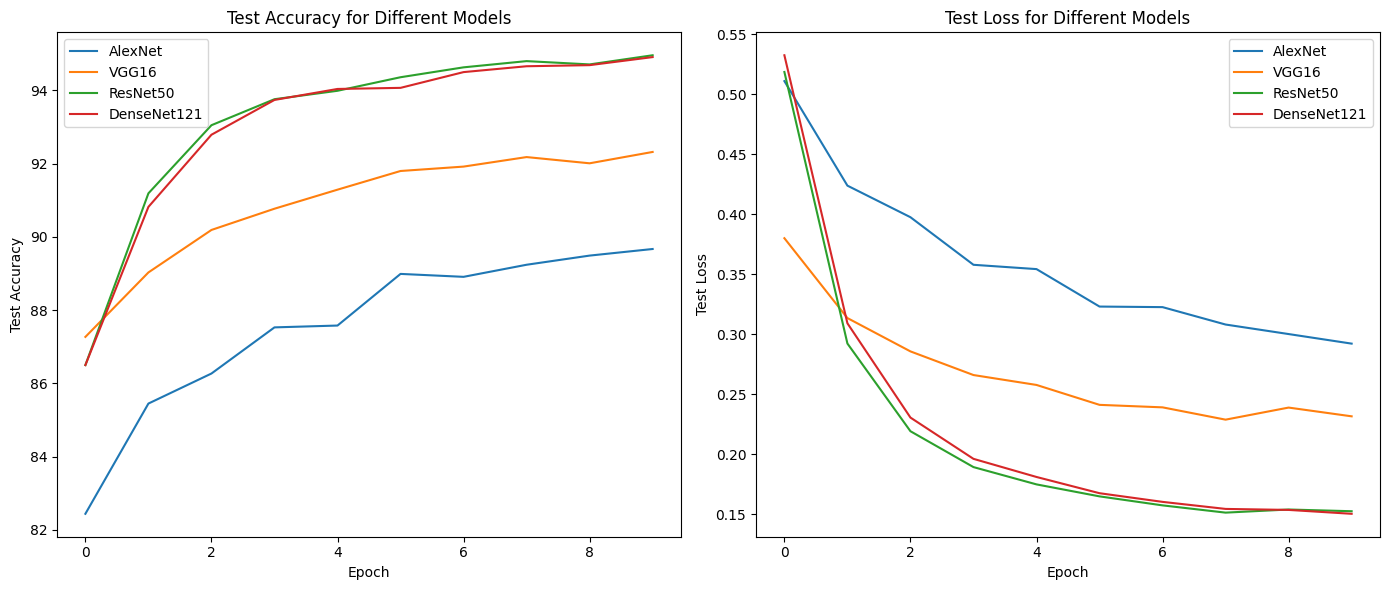

In [5]:
def train_and_test_model(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    results = {'train_loss': [], 'train_accuracy': [], 'Loss': [], 'Accuracy': []}
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in trainloader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            # Enable mixed precision
            with torch.cuda.amp.autocast():
                outputs = model(images)
                loss = criterion(outputs, labels)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train

        # Testing
        model.eval()
        test_loss = 0.0
        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_accuracy = 100 * correct_test / total_test

        results['train_loss'].append(train_loss / len(trainloader))
        results['train_accuracy'].append(train_accuracy)
        results['Loss'].append(test_loss / len(testloader))
        results['Accuracy'].append(test_accuracy)
        if (epoch + 1) % 5 == 0:
          print(f'Epoch {epoch+1}: Train Loss: {train_loss/len(trainloader):.4f}, Train Acc: {train_accuracy:.2f}%, Test Loss: {test_loss/len(testloader):.4f}, Test Acc: {test_accuracy:.2f}%')
    return results

# Example training and testing for all models
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = torch.cuda.amp.GradScaler() if torch.cuda.is_available() else None

criterion = nn.CrossEntropyLoss()

for model_name, model in models.items():
    if model_name == 'AlexNet' or model_name == 'VGG16':
        model.classifier[6] = nn.Linear(model.classifier[6].in_features, 10)
    elif model_name == 'ResNet50':
        model.fc = nn.Linear(model.fc.in_features, 10)
    elif model_name == 'DenseNet121':
        # The final classification layer for DenseNet is named 'classifier'
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Linear(num_ftrs, 10)
    model.to(device)

all_results = {}
for model_name, model in models.items():
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    print(f'Training and testing {model_name}...')
    results = train_and_test_model(model, trainloader, testloader, criterion, optimizer)
    all_results[model_name] = results

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
for model_name, results in all_results.items():
    plt.plot(results['Accuracy'], label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy for Different Models')
plt.legend()

# Plot test loss for all models
plt.subplot(1, 2, 2)
for model_name, results in all_results.items():
    plt.plot(results['Loss'], label=model_name)
plt.xlabel('Epoch')
plt.ylabel('Test Loss')
plt.title('Test Loss for Different Models')
plt.legend()

plt.tight_layout()
plt.show()

After fine-tuning each of the above architectures with proper learning rate, momemtum, etc., based on the above performance of the test set, ResNet50 is the best architecture for the CIFAR10 dataset. This is becasuse it has the highest accuracy and lowest loss and is also the fastest in getting to that accuracy/loss.